In [326]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Get OpenStreetMap Data

For this, we use the OSMPythonTools package as recommended by the OSM wiki. It allows us to access the Overpass API (a read-only API, perfect for what we are set to do), the OSM API, and the Nominatim access point. More info here: https://wiki.openstreetmap.org/wiki/OSMPythonTools

#### Which object does the way with the id 5887599 represent?

In [3]:
from OSMPythonTools.api import Api
api = Api()
way = api.query('way/5887599')

#### How many trees are in the OSM data of Vienna? And how many trees have there been in 2013?

In [7]:
# Find the id for the area Vienna
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
areaId = nominatim.query('Vienna, Austria').areaId()
print('Vienna Id:', areaId)

Vienna Id: 3600109166


In [9]:
# query the Overpass API for the numbe of trees in Vienna using the id we just retrieved.
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
result = overpass.query(query)
print('there are', result.countElements(), 'trees in Vienna')

there are 143275 trees in Vienna


In [10]:
# How many were there in 2013 ?
result = overpass.query(query, date='2013-01-01T00:00:00Z', timeout=60)
print('there were', result.countElements(), 'trees in Vienna in 2013')

[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;


there were 127690 trees in Vienna in 2013


#### How did the number of trees changed in Vienna, Paris and Berlin changed since 2013? 

In [11]:
from collections import OrderedDict
from OSMPythonTools.data import Data, dictRangeYears, ALL
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# The question has two "dimensions": the dimension of time, and the dimension of different cities: 
dimensions = OrderedDict([
    ('year', dictRangeYears(2013, 2017.5, 1)),
    ('city', OrderedDict({
        'berlin': 'Berlin, Germany',
        'paris': 'Paris, France',
        'vienna': 'Vienna, Austria',
    })),
])

In [12]:
# fetch the number of trees for the three cities, each year since 2013. It can take a while
overpass = Overpass()
def fetch(year, city):
    areaId = nominatim.query(city).areaId()
    query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
    return overpass.query(query, date=year, timeout=60).countElements()
data = Data(fetch, dimensions)

[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2015-01-01T00:00:00Z"][out:json];area(3600062422

In [153]:
# Plot it in a .jpg picture
data.plot(city=ALL, filename='example.png')

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'data' is not defined

In [15]:
# Or get it as a .csv
print(data.select(city=ALL).getCSV())

year,berlin,paris,vienna
2013.0,10180,1936,127690
2014.0,17971,26905,128906
2015.0,28277,90602,130279
2016.0,86769,103175,132294
2017.0,108432,103249,134617



# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

In [327]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
# place_name = "Bruntsfield, Edinburgh, Scotland"
place_name = "Fountainbridge, Edinburgh, Scotland"


# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

In [299]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

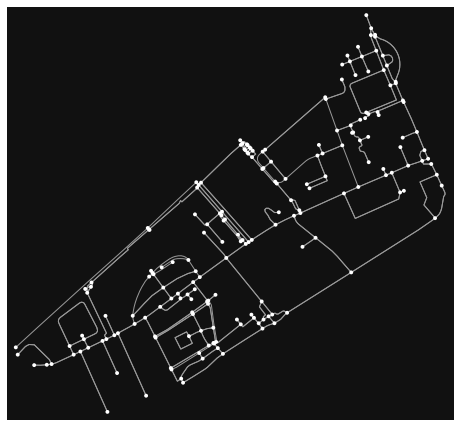

In [300]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

(-3.224, -3.208, 55.938, 55.946000000000005)

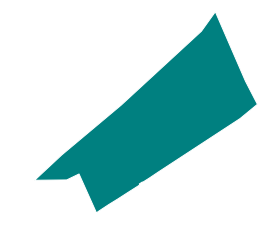

In [318]:
fig,ax = plt.subplots()
fig.patch.set_alpha(0)
area = ox.geocode_to_gdf(place_name)
area.plot(ax=ax, color='teal')
plt.axis('off')

# Get some specific info from OSM

(The outdated queries in the course have been updated as per changelog here: https://github.com/gboeing/osmnx/issues/526)

#### Bicycle lanes

As advised here: https://help.openstreetmap.org/questions/64879/get-all-bicycle-infrastructure-for-a-city

<blockquote>
To get all cycle infrastructure you will need to retrieve at least:
    <ul>
<li>all roads that have additional tags indicating cycle infrastructure (cycleway=lane and cycleway=track)</li>
<li>all highway=cycleway</li>
<li>all highway=footway and highway=path that allow bicycle use or are intended for such (bicycle=yes, bicycle=designated, bicycle=official)</li>
    </ul>
</blockquote>

#### Roads and highways

In [302]:
tags={'highway':True}
highways = ox.geometries_from_place(place_name, tags)
highways.highway.value_counts()

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


footway            62
service            43
residential        27
steps              24
tertiary           14
path               11
bus_stop            9
crossing            8
pedestrian          6
unclassified        6
give_way            6
traffic_signals     5
cycleway            3
Name: highway, dtype: int64

#### How to extract the bike lanes from this?

In [ ]:
if 0:
    cycleways = highways.loc['way', ['highway', 'bicycle','cycleway', 'cycleway:both','cycleway:both:lane', 'cycleway:left', 'cycleway:surface',
                                     'description', 'geometry','lane_markings','lanes', 'layer','nodes','oneway', 'oneway:bicycle','segregated',
                                     'surface']]

    i=0
    cycleways[cycleways.highway==cycleways.highway.unique()[i]].fillna('')

#### Restaurants

In [312]:
tags = {'amenity':True, 'landuse':['restaurant']}
restaurants = ox.geometries_from_place(place_name, tags)
restaurants.amenity.value_counts()

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


bench                 40
bicycle_parking       24
waste_basket          14
cafe                   8
parking                8
fast_food              8
restaurant             5
atm                    5
parking_entrance       3
bicycle_rental         3
telephone              3
recycling              2
pub                    2
motorcycle_parking     2
car_sharing            2
community_centre       2
vending_machine        1
bar                    1
library                1
casino                 1
cinema                 1
post_box               1
school                 1
arts_centre            1
clock                  1
Name: amenity, dtype: int64

#### Buildings

In [319]:
tags = {'building':True}
buildings = ox.geometries_from_place(place_name, tags=tags)
buildings.amenity.value_counts()

cafe       1
library    1
Name: amenity, dtype: int64

#### Bicycle rentals

In [323]:
tags = {'amenity':'bicycle_rental'}
bike_stations = ox.geometries_from_place(place_name, tags)

#### Parks and green spaces

In [328]:
tags = {'leisure':True}
leisure = ox.geometries_from_place(place_name, tags)
leisure.leisure.value_counts()

garden              58
picnic_table         4
sports_centre        1
escape_game          1
pitch                1
fitness_centre       1
miniature_golf       1
amusement_arcade     1
trampoline_park      1
park                 1
fitness_station      1
bowling_alley        1
playground           1
Name: leisure, dtype: int64

In [330]:
nodes, edges = ox.graph_to_gdfs(graph)

In [331]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layers
area = area.to_crs(projection)
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
leisure = leisure.to_crs(projection)
highways = highways.to_crs(projection)
bike_stations = bike_stations.to_crs(projection)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


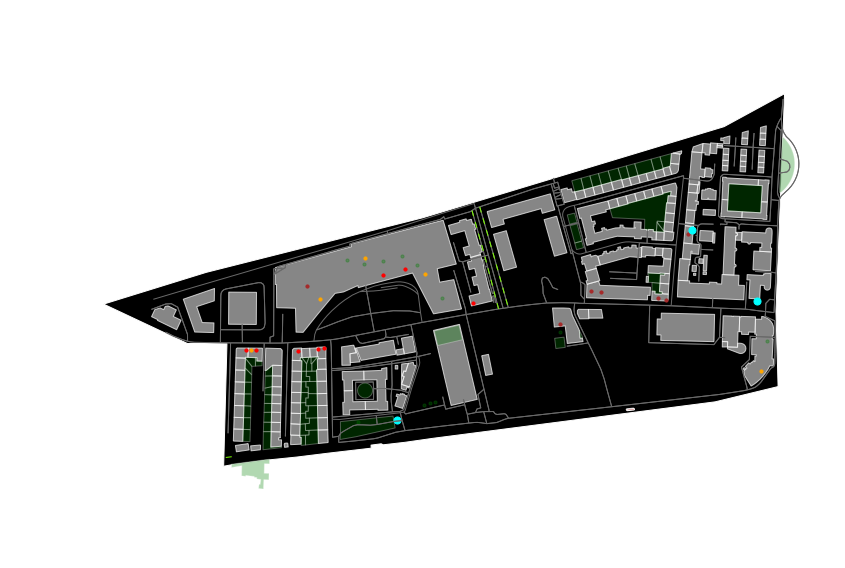

In [332]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# AREAS
# Plot the footprint
area.plot(ax=ax, facecolor='black')
# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)
# Plot churches
restaurants[restaurants.amenity=='place_of_worship'].plot(ax=ax, color='purple', alpha=.7, markersize=10)
# Plot parks
leisure.plot(ax=ax, color='green', alpha=0.3, markersize=10)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[highways.highway=='cycleway'].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot restaurants
restaurants[restaurants.amenity=='restaurant'].plot(ax=ax, color='orange', alpha=1, markersize=10)
# Plot cafes
restaurants[restaurants.amenity=='cafe'].plot(ax=ax, color='brown', alpha=1, markersize=10)
# Plot fast food
restaurants[restaurants.amenity=='fast_food'].plot(ax=ax, color='red', alpha=1, markersize=10)
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

Great! So now we know how to retrieve the road network and the bike sharing stations. There is still some work left to retrieve the bike lanes and cycleways in all their forms, but it's a promising start, thanks to osmnx

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


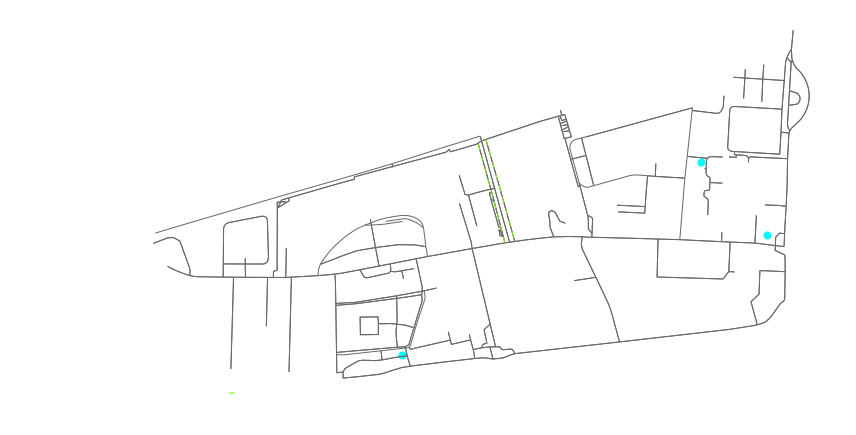

In [333]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[highways.highway=='cycleway'].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()